In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Tuple

import chex
from gymnax import EnvParams, EnvState

import os
import sys
import argparse

import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat
import gymnax
import optax
import flax
import pickle
import json
from jax.random import split
from functools import partial

import run
import run_bc
import util

from agents.basic import RandomAgent
from algos.ppo_dr import PPO

from agents.regular_transformer import BCTransformer
import create_env


In [3]:
d_obs_uni = 64
n_acts_uni = 18
T = 128

agent = BCTransformer(n_acts=n_acts_uni, n_layers=4, n_heads=8, d_embd=256, n_steps=T)


In [4]:
with open('../data/exp_icl/datasets/real/classic/name=CartPole-v1/dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)
obs_mean, obs_std = dataset['obs'].mean(axis=(0, 1)), dataset['obs'].std(axis=(0, 1))


In [14]:
with open('../data/exp_icl/train_bc/name=Asterix-MinAtar/metrics_train.pkl', 'rb') as f:
    metrics_train = pickle.load(f)

(0.0, 0.8)

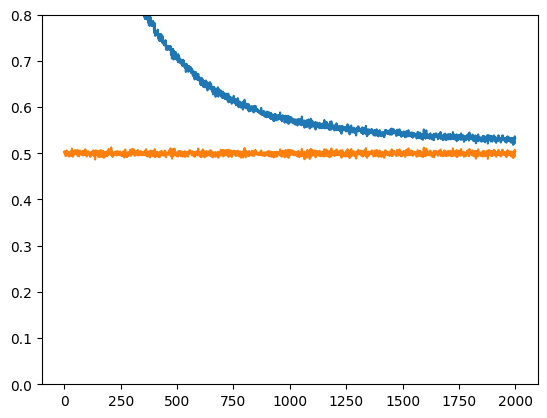

In [17]:
plt.plot(metrics_train['ce'].mean(axis=-1))
plt.plot(metrics_train['tar_entr'].mean(axis=-1))
plt.ylim(0, .8)

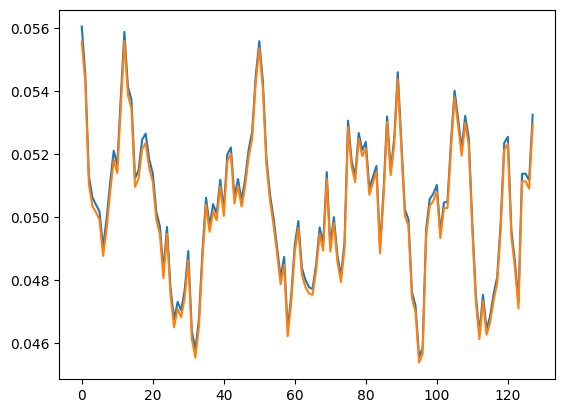

In [27]:
plt.plot(metrics_after['ce'].mean(axis=0))
plt.plot(metrics_after['tar_entr'].mean(axis=0))

In [7]:
with open('../data/exp_icl/train_bc/name=CartPole-v1/ckpt_final.pkl', 'rb') as f:
    agent_params = pickle.load(f)['params']

In [13]:
rng = jax.random.PRNGKey(0)
obs_mat = jax.random.orthogonal(rng, n=max(4, d_obs_uni), shape=())[:d_obs_uni, :4]

env = create_env.create_env('name=CartPole-v1')

env_step = jax.jit(jax.vmap(env.step, in_axes=(0, 0, 0, None)))
agent_forward = jax.jit(jax.vmap(agent.apply, in_axes=(None, 0, 0)))


In [11]:
rng = jax.random.PRNGKey(0)

n_envs = 128

rng, _rng = split(rng)
env_params = env.sample_params(_rng)

env_step = jax.jit(jax.vmap(env.step, in_axes=(0, 0, 0, None)))
agent_forward = jax.jit(jax.vmap(agent.apply, in_axes=(None, 0, 0)))

obs, state = jax.vmap(env.reset, in_axes=(0, None))(split(_rng, n_envs), env_params)
obs = ((obs - obs_mean) / obs_std)@obs_mat.T

act0 = jnp.zeros((n_envs, ), dtype=int)
x_obs, x_act = [obs], [act0]
rews, dones, rets = [], [], []

pbar = tqdm(range(1000))
for t in pbar:

    len_obs = len(x_obs)
    if len_obs<T:
        x_obsv, x_actv = jnp.stack(x_obs+[obs]*(T-len_obs), axis=1), jnp.stack(x_act+[act0]*(T-len_obs), axis=1)
        logits = agent_forward(agent_params, x_obsv, x_actv)
        rng, _rng = split(rng)
        act = jax.random.categorical(_rng, logits[:, len_obs-1, :2])
    else:
        x_obsv, x_actv = jnp.stack(x_obs, axis=1), jnp.stack(x_act, axis=1)
        logits = agent_forward(agent_params, x_obsv, x_actv)
        rng, _rng = split(rng)
        act = jax.random.categorical(_rng, logits[:, -1, :2])
        # act = logits[:, time, :2].argmax(axis=-1)
    
    rng, _rng = split(rng)
    obs, state, rew, done, info = env_step(split(_rng, n_envs), state, act, env_params)
    obs = ((obs - obs_mean) / obs_std)@obs_mat.T
    rets.append(info['returned_episode_returns'])
    rews.append(rew)
    dones.append(done)

    x_obs.append(obs)
    x_act[-1] = act
    x_act.append(act0)
    x_obs, x_act = x_obs[-128:], x_act[-128:]

    pbar.set_postfix(rets=rets[-1].mean())

rews = jnp.stack(rews, axis=0)
dones = jnp.stack(dones, axis=0)
rets = jnp.stack(rets, axis=0)

score = rets[-500:, :].mean()

  0%|          | 0/1000 [00:00<?, ?it/s]

499.8174133300781

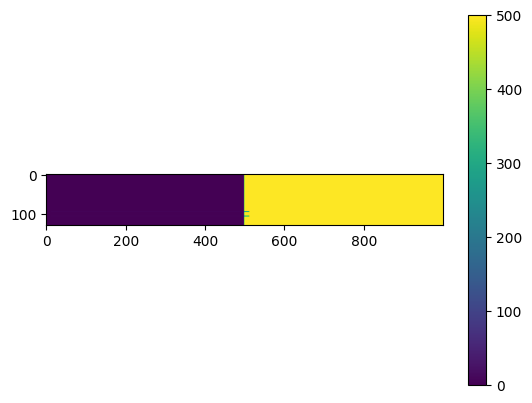

In [12]:
plt.imshow(rets.T)
plt.colorbar()
score.item()

In [17]:
def calc_score(agent_params):
    rng = jax.random.PRNGKey(0)

    n_envs = 128

    rng, _rng = split(rng)
    env_params = env.sample_params(_rng)

    env_step = jax.jit(jax.vmap(env.step, in_axes=(0, 0, 0, None)))
    agent_forward = jax.jit(jax.vmap(agent.apply, in_axes=(None, 0, 0)))

    obs, state = jax.vmap(env.reset, in_axes=(0, None))(split(_rng, n_envs), env_params)
    obs = ((obs - obs_mean) / obs_std)@obs_mat.T

    act0 = jnp.zeros((n_envs, ), dtype=int)
    x_obs, x_act = [obs], [act0]
    rews, dones, rets = [], [], []

    pbar = tqdm(range(700), leave=False)
    for t in pbar:
        len_obs = len(x_obs)
        if len_obs<T:
            x_obsv, x_actv = jnp.stack(x_obs+[obs]*(T-len_obs), axis=1), jnp.stack(x_act+[act0]*(T-len_obs), axis=1)
            logits = agent_forward(agent_params, x_obsv, x_actv)
            rng, _rng = split(rng)
            act = jax.random.categorical(_rng, logits[:, len_obs-1, :2])
        else:
            x_obsv, x_actv = jnp.stack(x_obs, axis=1), jnp.stack(x_act, axis=1)
            logits = agent_forward(agent_params, x_obsv, x_actv)
            rng, _rng = split(rng)
            act = jax.random.categorical(_rng, logits[:, -1, :2])
            # act = logits[:, time, :2].argmax(axis=-1)
        
        rng, _rng = split(rng)
        obs, state, rew, done, info = env_step(split(_rng, n_envs), state, act, env_params)
        obs = ((obs - obs_mean) / obs_std)@obs_mat.T
        rets.append(info['returned_episode_returns'])
        rews.append(rew)
        dones.append(done)

        x_obs.append(obs)
        x_act[-1] = act
        x_act.append(act0)
        x_obs, x_act = x_obs[-128:], x_act[-128:]

        pbar.set_postfix(rets=rets[-1].mean())

    rews = jnp.stack(rews, axis=0)
    dones = jnp.stack(dones, axis=0)
    rets = jnp.stack(rets, axis=0)

    score = rets[-100:, :].mean()
    return score


In [18]:
method2scores = {}
for method in ['scratch', 'name=CartPole-v1', 'name=csmdp;i_d=0;i_s=0;t_a=4;t_c=2;t_l=1;t_s=0;o_d=1;o_c=1;r_c=0;tl=64']:
    scores = []
    for ckpt in tqdm([0, 3, 'final']):
        with open(f'../data/exp_icl/test_bc/name=CartPole-v1/{method}/ckpt_{ckpt}.pkl', 'rb') as f:
            agent_params = pickle.load(f)['params']
        score = calc_score(agent_params)
        scores.append(score)
    method2scores[method] = jnp.stack(scores)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Text(0.5, 0, 'Finetuning Steps')

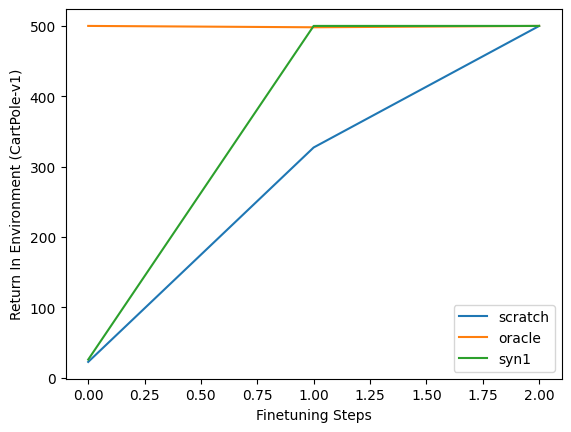

In [19]:
plt.plot(method2scores['scratch'], label='scratch')
plt.plot(method2scores['name=CartPole-v1'], label='oracle')
plt.plot(method2scores['name=csmdp;i_d=0;i_s=0;t_a=4;t_c=2;t_l=1;t_s=0;o_d=1;o_c=1;r_c=0;tl=64'], label='syn1')
plt.legend()
plt.ylabel('Return In Environment (CartPole-v1)')
plt.xlabel('Finetuning Steps')



In [5]:
from compile_experiment import envs_test

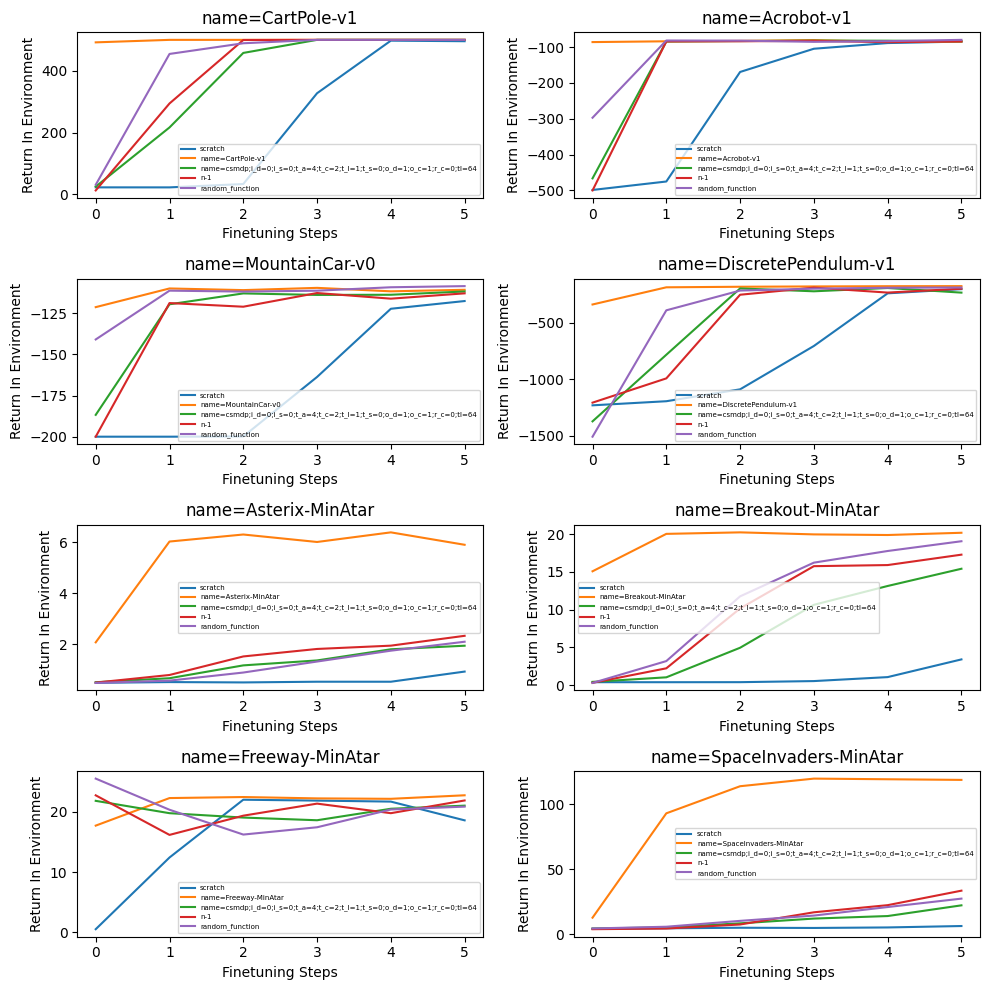

In [7]:
plt.figure(figsize=(10, 10))
for i_plt, env_id in enumerate(envs_test):
    plt.subplot(4, 2, i_plt+1)
    method2scores = {}
    for method in ['scratch', env_id, 'name=csmdp;i_d=0;i_s=0;t_a=4;t_c=2;t_l=1;t_s=0;o_d=1;o_c=1;r_c=0;tl=64', 'n-1', 'random_function']:
        scores = []
        for ckpt in [0, 1, 2, 3, 4, 'final']:
            with open(f'../data/exp_icl/test_bc/{env_id}/{method}/ckpt_{ckpt}.pkl.unroll.pkl', 'rb') as f:
                score = pickle.load(f)['mean']
            scores.append(score)
        method2scores[method] = jnp.stack(scores)

    for k, v in method2scores.items():
        plt.plot(v, label=k)
    plt.legend(fontsize=5)
    plt.ylabel(f'Return In Environment')
    plt.xlabel('Finetuning Steps')
    plt.title(env_id)
plt.tight_layout()
plt.show()
